CAM(Class Activation Mapping): CNN이 특정 클라스 이미지를 그 클라스라고 예측하게 한 그 이미지 내의 위치 정보를 의미

CAM의 단점은 Global Average Pooling 레이어가 필요하다는 것

Grad-CAM은 Global Average Pooling 레이어에 의존하지 않는 아이디어

copied from https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

# 환경 준비

In [1]:
!pip install --upgrade tf-keras-vis

     |████████████████████████████████| 53 kB 2.0 MB/s 


In [2]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

In [3]:
from tensorflow.keras import backend as K
from tf_keras_vis.utils import normalize
from matplotlib import cm

# 모델 로딩

VGG16을 사용한다.

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load model
model = Model(weights='imagenet', include_top=True)   # include_top=True : 뒤에까지 다 실행하겠다
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# 데이터 준비

In [5]:
# 그림 3장 다운로드
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/bear.jpg
!wget https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/soldiers.jpg

--2022-01-25 08:20:32--  https://github.com/keisen/tf-keras-vis/raw/master/docs/examples/images/goldfish.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg [following]
--2022-01-25 08:20:32--  https://raw.githubusercontent.com/keisen/tf-keras-vis/master/docs/examples/images/goldfish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8833 (8.6K) [image/jpeg]
Saving to: ‘goldfish.jpg’

goldfish.jpg        100%[===================>]   8.63K  --.-KB/s    in 0s      

2022-01-25 08:20:32 (65.2 MB/s) - ‘goldfish.jpg’ saved [8833/8833]


In [6]:
from tensorflow.keras.preprocessing.image import load_img

# Load images & resize
img1 = load_img('goldfish.jpg', target_size=(224, 224))
img2 = load_img('bear.jpg', target_size=(224, 224))
img3 = load_img('soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

GOLDFISH_CATEGORY_INDEX = 1
BEAR_CATEGORY_INDEX = 294
ASSAULT_RIFLE_CATEGORY_INDEX = 413

labels = [GOLDFISH_CATEGORY_INDEX, BEAR_CATEGORY_INDEX, ASSAULT_RIFLE_CATEGORY_INDEX]

In [7]:
print(images.shape)
print(labels)

(3, 224, 224, 3)
[1, 294, 413]


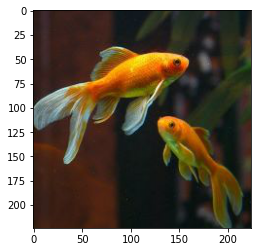

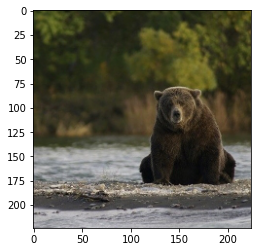

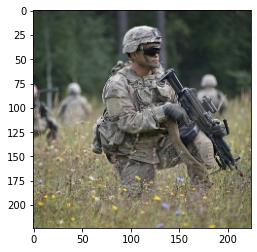

In [8]:
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

# GradCAM++ 실행

In [9]:
def draw_gradcam(model, images, labels, preprocess):
    
    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    from tf_keras_vis.gradcam import GradcamPlusPlus

    gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    # Generate heatmap with GradCAM++
    cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()
            

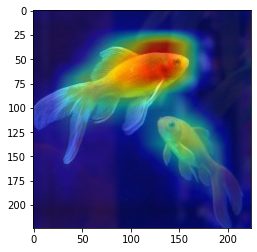

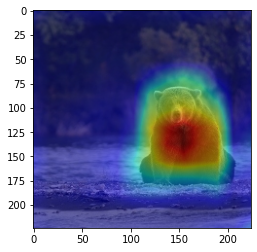

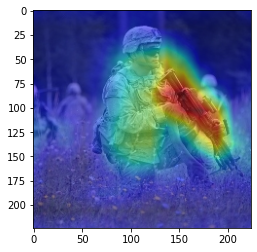

In [10]:
def preprocess(img):
    return preprocess_input(img)

draw_gradcam(model, images, labels, preprocess)

# Faster-ScoreCAM 실행

In [11]:
def draw_fast_score_gradcam(model, images, labels, preprocess):

    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m    

    from tf_keras_vis.scorecam import ScoreCAM

    scorecam = ScoreCAM(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    cam = scorecam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER, max_N=10)

    cam = normalize(cam)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()                


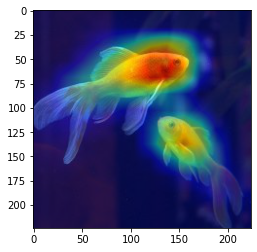

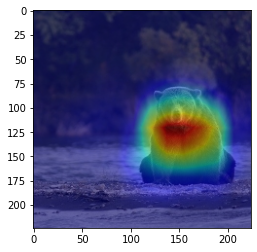

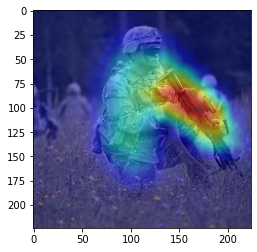

In [12]:
def preprocess(img):
    return preprocess_input(img)
    
draw_fast_score_gradcam(model, images, labels, preprocess)

# Vannilla_CNN

template_image_data_vannilla_cnn_classification 참고

## 영상 데이터 분류 by vanilla CNN template

## 데이터 준비


<br>

데이터는 다음과 같이 구성됨

```
dogs/
    train/
        class1/
            file1.jpg
            file2.jpg
             ...
        class2/ 
            file21.jpg
            file22.jpg
             ...    
        class3/
            file31.jpg
            file32.jpg
             ...
        ...
    test/
        class1/
            file8.jpg
            file9.jpg
             ...
        class2/ 
            file28.jpg
            file29.jpg
             ...    
        class3/
            file38.jpg
            file39.jpg
             ...
        ...
    
```

In [13]:
!rm -rf dogs_prepared.tar.gz
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
!ls -al  

--2022-01-25 08:20:58--  https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/dogs_prepared.tar.gz [following]
--2022-01-25 08:20:59--  https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/dogs_prepared.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62898132 (60M) [application/octet-stream]
Saving to: ‘dogs_prepared.tar.gz’

dogs_prepared.tar.g 100%[===================>]  59.98M   272MB/s    in 0.2s    

2022-01-25 08:21:01 (272 MB

In [14]:
!rm -rf dogs_prepared
!tar xvfz dogs_prepared.tar.gz
!ls -al dogs_prepared

dogs_prepared/
dogs_prepared/._test
dogs_prepared/test/
dogs_prepared/train/
dogs_prepared/train/n02085620-Chihuahua/
dogs_prepared/train/n02085782-Japanese_spaniel/
dogs_prepared/train/n02085936-Maltese_dog/
dogs_prepared/train/n02086079-Pekinese/
dogs_prepared/train/n02086240-Shih-Tzu/
dogs_prepared/train/n02086646-Blenheim_spaniel/
dogs_prepared/train/n02086910-papillon/
dogs_prepared/train/n02087046-toy_terrier/
dogs_prepared/train/n02087394-Rhodesian_ridgeback/
dogs_prepared/train/n02088094-Afghan_hound/
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1003.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1007.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1023.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10263.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10715.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10822.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10832.jpg
dogs_prepared/train/n02088094-Afghan_hound/n020

## Template

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

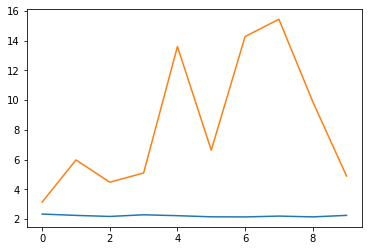

6/6 [==============================] - 2s 256ms/step - loss: 4.8905 - acc: 0.1031
loss= 4.890491962432861
acc= 0.10309278219938278


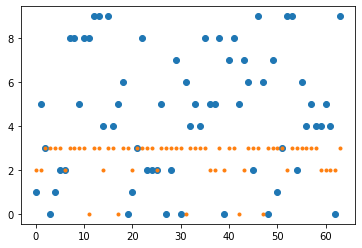

In [15]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

model = keras.Sequential()
model.add(Input((224,224,3)))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

def normalize(image):
  return image/255.0

preprocessor = normalize
BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/BATCH_SIZE,  
      validation_steps=test_data_generator.samples/BATCH_SIZE,      
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/BATCH_SIZE
)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = next(iter(test_data_generator))
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


In [16]:
test_x, test_y = next(iter(test_data_generator))

## grad_cam++

In [17]:
!pip install --upgrade tf-keras-vis

In [18]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tf_keras_vis.utils import normalize
from matplotlib import cm

In [19]:
def draw_gradcam(model, images, labels, preprocess):
    
    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    from tf_keras_vis.gradcam import GradcamPlusPlus

    gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    # Generate heatmap with GradCAM++
    cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()  


# 실행이 안됨
# 전이학습

template_image_data_transfer_learning_classification 참고

## 영상 데이터 분류 by 전이학습 template

## 데이터 준비


<br>

데이터는 다음과 같이 구성됨

```
dogs/
    train/
        class1/
            file1.jpg
            file2.jpg
             ...
        class2/ 
            file21.jpg
            file22.jpg
             ...    
        class3/
            file31.jpg
            file32.jpg
             ...
        ...
    test/
        class1/
            file8.jpg
            file9.jpg
             ...
        class2/ 
            file28.jpg
            file29.jpg
             ...    
        class3/
            file38.jpg
            file39.jpg
             ...
        ...
    
```

In [20]:
!rm -rf dogs_prepared.tar.gz
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
!ls -al  

--2022-01-25 08:25:28--  https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/dogs_prepared.tar.gz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/dogs_prepared.tar.gz [following]
--2022-01-25 08:25:28--  https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/dogs_prepared.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62898132 (60M) [application/octet-stream]
Saving to: ‘dogs_prepared.tar.gz’

dogs_prepared.tar.g 100%[===================>]  59.98M   327MB/s    in 0.2s    

2022-01-25 08:25:28 (327 MB

In [21]:
!rm -rf dogs_prepared
!tar xvfz dogs_prepared.tar.gz
!ls -al dogs_prepared

dogs_prepared/
dogs_prepared/._test
dogs_prepared/test/
dogs_prepared/train/
dogs_prepared/train/n02085620-Chihuahua/
dogs_prepared/train/n02085782-Japanese_spaniel/
dogs_prepared/train/n02085936-Maltese_dog/
dogs_prepared/train/n02086079-Pekinese/
dogs_prepared/train/n02086240-Shih-Tzu/
dogs_prepared/train/n02086646-Blenheim_spaniel/
dogs_prepared/train/n02086910-papillon/
dogs_prepared/train/n02087046-toy_terrier/
dogs_prepared/train/n02087394-Rhodesian_ridgeback/
dogs_prepared/train/n02088094-Afghan_hound/
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1003.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1007.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_1023.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10263.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10715.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10822.jpg
dogs_prepared/train/n02088094-Afghan_hound/n02088094_10832.jpg
dogs_prepared/train/n02088094-Afghan_hound/n020

## Template

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               17662208  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 25,434,371
Trainable params: 17,665,290
N

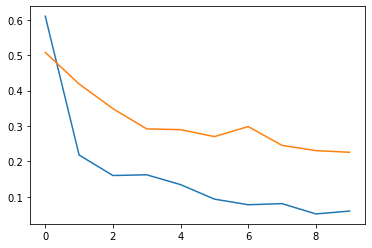

7/7 [==============================] - 2s 210ms/step - loss: 0.2260 - acc: 0.9459
loss= 0.22601117193698883
acc= 0.9458763003349304


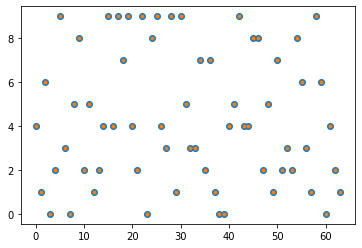

label category index = 4.0
predicted category index = 4
predicted category name = n02086240-Shih-Tzu


In [22]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "dogs_prepared/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


## grad_cam++

In [23]:
!pip install --upgrade tf-keras-vis

In [24]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tf_keras_vis.utils import normalize
from matplotlib import cm

In [25]:
def draw_gradcam(model, images, labels, preprocess):
    
    X = preprocess(images)

    def loss(output):
        return [ output[i][labels[i]] for i in range(len(labels)) ]

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    from tf_keras_vis.gradcam import GradcamPlusPlus

    gradcam = GradcamPlusPlus(model, model_modifier, clone=False)

    TARGET_LAYER_NUMBER = -1 # 마지막 층
    # Generate heatmap with GradCAM++
    cam = gradcam(loss, X, penultimate_layer=TARGET_LAYER_NUMBER)

    for i in range(len(images)):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        plt.imshow(images[i])
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.show()

In [33]:
# images, labels = next(iter(test_data_generator))  # <-------------------

# labels = labels.astype(np.int)  # <------------------

def preprocess(img):
    return preprocess_input(img)  # <------------------ 
    # return img
    
draw_gradcam(model, images, labels, preprocess)

ValueError: ignored